Epoch [0/5000], Loss AB: 0.7055, Loss E: 16.0914, Accuracy AB: 0.3438, Accuracy E: 0.5625
Epoch [100/5000], Loss AB: 0.6840, Loss E: 22.4580, Accuracy AB: 0.6250, Accuracy E: 0.4062
Epoch [200/5000], Loss AB: 0.7018, Loss E: 19.2547, Accuracy AB: 0.4062, Accuracy E: 0.5000
Epoch [300/5000], Loss AB: 0.6861, Loss E: 6.7811, Accuracy AB: 0.5625, Accuracy E: 0.6562
Epoch [400/5000], Loss AB: 0.6987, Loss E: 13.1242, Accuracy AB: 0.4688, Accuracy E: 0.4688
Epoch [500/5000], Loss AB: 0.7074, Loss E: 6.8580, Accuracy AB: 0.3438, Accuracy E: 0.5312
Epoch [600/5000], Loss AB: 0.7025, Loss E: 19.2961, Accuracy AB: 0.2812, Accuracy E: 0.4688
Epoch [700/5000], Loss AB: 0.6975, Loss E: 25.4081, Accuracy AB: 0.3750, Accuracy E: 0.4688
Epoch [800/5000], Loss AB: 0.6926, Loss E: 10.0294, Accuracy AB: 0.4688, Accuracy E: 0.4688
Epoch [900/5000], Loss AB: 0.7006, Loss E: 9.9246, Accuracy AB: 0.4688, Accuracy E: 0.5625
Epoch [1000/5000], Loss AB: 0.6960, Loss E: 19.3123, Accuracy AB: 0.4688, Accuracy E:

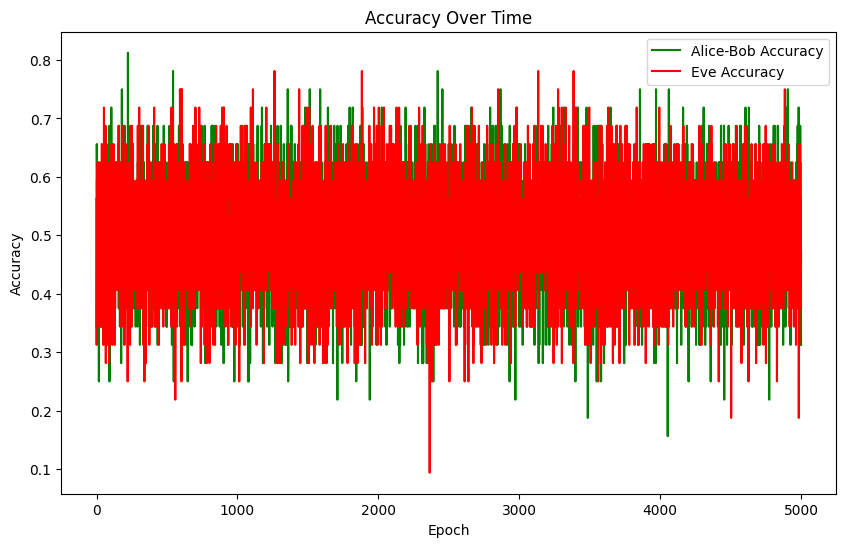

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the smart contract length (message) and key length
contract_length = 32  # Length of the smart contract message
key_length = 32  # Length of the encryption key

# Define models for Alice, Bob, and Eve
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        self.fc1 = nn.Linear(contract_length + key_length, 8 * (contract_length + key_length))
        self.fc2 = nn.Linear(8 * (contract_length + key_length), 4 * (contract_length + key_length))
        self.fc3 = nn.Linear(4 * (contract_length + key_length), contract_length)
        self.dropout = nn.Dropout(0.3)  # Adding dropout to prevent overfitting

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary compatibility
        return x


class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        self.fc1 = nn.Linear(contract_length, 4 * contract_length)
        self.fc2 = nn.Linear(4 * contract_length, contract_length)
        self.dropout = nn.Dropout(0.3)  # Adding dropout to prevent overfitting

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.sigmoid(self.fc2(x)))  # Sigmoid for binary output
        return x

# Initialize models
alice_bob = AliceBobNet()
eve = EveNet()

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer_ab = optim.Adam(alice_bob.parameters(), lr=0.0005)  # Fine-tuned learning rate
optimizer_e = optim.Adam(eve.parameters(), lr=0.0001)

# Training parameters
epochs = 5000
losses_ab, losses_e, accuracies_ab, accuracies_e = [], [], [], []

# Training loop
for epoch in range(epochs):
    # Generate random smart contracts (binary data) and keys
    contracts = torch.randint(0, 2, (1, contract_length)).type(torch.float32)
    keys = torch.randint(0, 2, (1, key_length)).type(torch.float32)

    # Combine contract and key for Alice
    alice_input = torch.cat((contracts, keys), dim=1)

    # Encrypt contract
    encrypted_contract = alice_bob(alice_input).detach()

    # Decrypt contract (Bob uses the same model as Alice)
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)

    # Eve's attempt to decrypt
    eve_decrypted_contract = eve(encrypted_contract)

    # Post-process outputs to binary (threshold at 0.5)
    decrypted_contract_binary = (decrypted_contract > 0.5).float()
    eve_decrypted_binary = (eve_decrypted_contract > 0.5).float()

    # Compute losses
    loss_ab = criterion(decrypted_contract, contracts)
    loss_e = criterion(eve_decrypted_contract, contracts)

    # Backpropagation and optimization
    if epoch % 2 == 0:  # Update Alice-Bob more frequently
        optimizer_ab.zero_grad()
        loss_ab.backward()
        optimizer_ab.step()

    if epoch % 4 == 0:  # Update Eve less frequently
        optimizer_e.zero_grad()
        loss_e.backward()
        optimizer_e.step()

    # Compute accuracies
    accuracy_ab = torch.mean((decrypted_contract_binary == contracts).float()).item()
    accuracy_e = torch.mean((eve_decrypted_binary == contracts).float()).item()

    # Store metrics
    accuracies_ab.append(accuracy_ab)
    accuracies_e.append(accuracy_e)
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f}, "
              f"Accuracy AB: {accuracy_ab:.4f}, Accuracy E: {accuracy_e:.4f}")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), accuracies_ab, label='Alice-Bob Accuracy', color='green')
plt.plot(range(epochs), accuracies_e, label='Eve Accuracy', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Pretraining AliceBobNet...
[Pretrain AliceBobNet] Epoch 0/2000, Loss: 19.6401
[Pretrain AliceBobNet] Epoch 100/2000, Loss: 13.1390
[Pretrain AliceBobNet] Epoch 200/2000, Loss: 3.6839
[Pretrain AliceBobNet] Epoch 300/2000, Loss: 9.9571
[Pretrain AliceBobNet] Epoch 400/2000, Loss: 3.7981
[Pretrain AliceBobNet] Epoch 500/2000, Loss: 9.9521
[Pretrain AliceBobNet] Epoch 600/2000, Loss: 3.7430
[Pretrain AliceBobNet] Epoch 700/2000, Loss: 6.8830
[Pretrain AliceBobNet] Epoch 800/2000, Loss: 6.8680
[Pretrain AliceBobNet] Epoch 900/2000, Loss: 6.8629
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 6.8453
[Pretrain AliceBobNet] Epoch 1100/2000, Loss: 9.9912
[Pretrain AliceBobNet] Epoch 1200/2000, Loss: 3.7408
[Pretrain AliceBobNet] Epoch 1300/2000, Loss: 3.7412
[Pretrain AliceBobNet] Epoch 1400/2000, Loss: 6.8999
[Pretrain AliceBobNet] Epoch 1500/2000, Loss: 6.8573
[Pretrain AliceBobNet] Epoch 1600/2000, Loss: 9.9631
[Pretrain AliceBobNet] Epoch 1700/2000, Loss: 3.7307
[Pretrain AliceBobNet] Epoch 

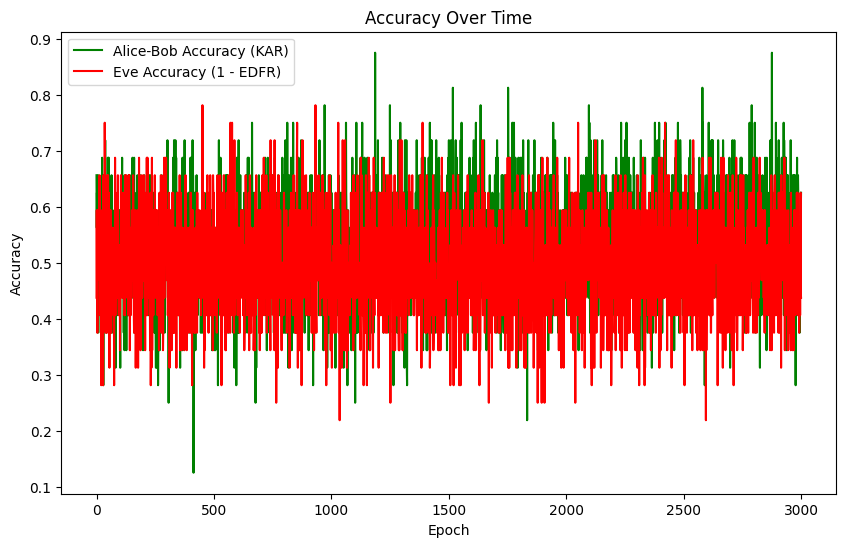

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --------------------
# Hyperparameters
# --------------------
contract_length = 32
key_length = 32

# --------------------
# Define Models
# --------------------
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        self.fc1 = nn.Linear(contract_length + key_length, 16 * (contract_length + key_length))
        self.fc2 = nn.Linear(16 * (contract_length + key_length), 8 * (contract_length + key_length))
        self.fc3 = nn.Linear(8 * (contract_length + key_length), 4 * (contract_length + key_length))
        self.fc4 = nn.Linear(4 * (contract_length + key_length), contract_length)
        self.dropout = nn.Dropout(0.4)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        """
        Forward pass for both Alice (encryption) and Bob (decryption).
        They share the same network architecture/weights.
        """
        # Residual path
        residual = torch.sigmoid(self.residual(x))

        # Feedforward path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))

        # Final combination with residual
        x = torch.sigmoid(self.fc4(x)) + residual
        return x

class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        self.fc1 = nn.Linear(contract_length, 8 * contract_length)
        self.fc2 = nn.Linear(8 * contract_length, 4 * contract_length)
        self.fc3 = nn.Linear(4 * contract_length, contract_length)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        """
        Forward pass for Eve to attempt to decrypt the contract without the key.
        """
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.sigmoid(self.fc3(x)))
        return x

# --------------------
# Initialize
# --------------------
alice_bob = AliceBobNet()
eve = EveNet()

# --------------------
# Loss and Optimizers
# --------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=0.0005, weight_decay=1e-4)
optimizer_e = optim.AdamW(eve.parameters(), lr=0.00005, weight_decay=1e-4)

# --------------------
# Training Hyperparams
# --------------------
pretrain_epochs = 2000
main_epochs = 3000

# For logging
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []

# =====================================================
#  Stage 1: Pretrain AliceBobNet (encrypt-decrypt)
# =====================================================
print("Pretraining AliceBobNet...")
for epoch in range(pretrain_epochs):
    # 1. Generate random binary data
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    # 2. Alice encrypts
    alice_input = torch.cat((contracts, keys), dim=1)
    encrypted_contract = alice_bob(alice_input)

    # 3. Bob decrypts (again uses the same net)
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)
    decrypted_contract_clamped = torch.clamp(decrypted_contract, 0.0, 1.0)

    # 4. Compute loss
    loss = criterion(decrypted_contract_clamped, contracts)

    # 5. Backprop
    optimizer_ab.zero_grad()
    loss.backward()
    optimizer_ab.step()

    # 6. Print progress
    if epoch % 100 == 0:
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss.item():.4f}")

# =====================================================
#  Stage 2: Pretrain EveNet (try to decrypt)
# =====================================================
print("\nPretraining EveNet...")
for epoch in range(pretrain_epochs):
    # 1. Generate random binary data
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    # 2. Alice encrypts (use with no gradient for Alice-Bob)
    alice_input = torch.cat((contracts, keys), dim=1)
    with torch.no_grad():
        encrypted_contract = alice_bob(alice_input)

    # 3. Eve tries to decrypt
    eve_decrypted_contract = eve(encrypted_contract)
    eve_decrypted_contract_clamped = torch.clamp(eve_decrypted_contract, 0.0, 1.0)

    # 4. Compute loss
    loss = criterion(eve_decrypted_contract_clamped, contracts)

    # 5. Backprop
    optimizer_e.zero_grad()
    loss.backward()
    optimizer_e.step()

    # 6. Print progress
    if epoch % 100 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss.item():.4f}")

# =====================================================
#  Stage 3: Joint Training (Alice-Bob vs. Eve)
# =====================================================
print("\nJoint Training (Alice-Bob vs. Eve)...")
for epoch in range(main_epochs):

    # -----------------------
    # 1. Generate data
    # -----------------------
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    # -----------------------
    # 2. Alice encrypts
    # -----------------------
    alice_input = torch.cat((contracts, keys), dim=1)
    encrypted_contract = alice_bob(alice_input)

    # Add noise
    noise = torch.randn_like(encrypted_contract) * torch.rand(1).item() * 0.1
    encrypted_contract_with_noise = encrypted_contract + noise  # not in-place

    # -----------------------
    # 3. Bob decrypts
    # -----------------------
    bob_input = torch.cat((encrypted_contract_with_noise, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)
    decrypted_contract_clamped = torch.clamp(decrypted_contract, 0.0, 1.0)

    # -----------------------
    # 4. Eve tries to decrypt
    # -----------------------
    eve_decrypted_contract = eve(encrypted_contract_with_noise)
    eve_decrypted_contract_clamped = torch.clamp(eve_decrypted_contract, 0.0, 1.0)

    # -----------------------
    # 5. Compute losses
    # -----------------------
    loss_ab = criterion(decrypted_contract_clamped, contracts)  # Alice-Bob
    loss_e = criterion(eve_decrypted_contract_clamped, contracts)  # Eve

    # -----------------------
    # 6. Zero out both optimizers
    # -----------------------
    optimizer_ab.zero_grad()
    optimizer_e.zero_grad()

    # -----------------------
    # 7. Backpropagation
    # -----------------------
    # Always backprop for Alice-Bob
    loss_ab.backward(retain_graph=True)

    # Backprop for Eve every 15 epochs
    if epoch % 15 == 0:
        loss_e.backward()

    # -----------------------
    # 8. Update Weights
    # -----------------------
    optimizer_ab.step()
    if epoch % 15 == 0:
        optimizer_e.step()

    # -----------------------
    # 9. Compute Accuracy
    # -----------------------
    decrypted_contract_binary = (decrypted_contract_clamped > 0.5).float()
    eve_decrypted_binary = (eve_decrypted_contract_clamped > 0.5).float()

    accuracy_ab = torch.mean((decrypted_contract_binary == contracts).float()).item()
    accuracy_e = torch.mean((eve_decrypted_binary == contracts).float()).item()

    # -----------------------
    # 10. Store & Print
    # -----------------------
    accuracies_ab.append(accuracy_ab)
    accuracies_e.append(accuracy_e)
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())

    if epoch % 100 == 0:
        print(f"[Joint Training] Epoch {epoch}/{main_epochs}, "
              f"Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f}, "
              f"Accuracy AB: {accuracy_ab:.4f}, Accuracy E: {accuracy_e:.4f}")

# =====================================================
# Final KAR & EDFR
# =====================================================
kar = sum(accuracies_ab) / len(accuracies_ab) * 100
edfr = 100 - (sum(accuracies_e) / len(accuracies_e) * 100)
print(f"\nFinal Results: KAR = {kar:.2f}%, EDFR = {edfr:.2f}%")

# =====================================================
# Plot results
# =====================================================
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies_ab)), accuracies_ab, label='Alice-Bob Accuracy (KAR)', color='green')
plt.plot(range(len(accuracies_e)), accuracies_e, label='Eve Accuracy (1 - EDFR)', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Pretraining Alice-Bob (Stage 1)...
[Pretrain AliceBobNet] Epoch 0/1000, Loss: 31.9084, Accuracy: 50.24%
[Pretrain AliceBobNet] Epoch 100/1000, Loss: 1.5729, Accuracy: 49.85%
[Pretrain AliceBobNet] Epoch 200/1000, Loss: 0.6985, Accuracy: 49.46%
[Pretrain AliceBobNet] Epoch 300/1000, Loss: 0.6971, Accuracy: 50.39%
[Pretrain AliceBobNet] Epoch 400/1000, Loss: 0.6914, Accuracy: 52.59%
[Pretrain AliceBobNet] Epoch 500/1000, Loss: 0.6844, Accuracy: 52.83%
[Pretrain AliceBobNet] Epoch 600/1000, Loss: 0.6968, Accuracy: 51.81%
[Pretrain AliceBobNet] Epoch 700/1000, Loss: 0.6954, Accuracy: 50.83%
[Pretrain AliceBobNet] Epoch 800/1000, Loss: 0.6786, Accuracy: 56.15%
[Pretrain AliceBobNet] Epoch 900/1000, Loss: 0.7338, Accuracy: 52.39%

Pretraining Eve (Stage 2)...
[Pretrain EveNet] Epoch 0/1000, Loss: 0.6923, Accuracy Eve: 50.88%
[Pretrain EveNet] Epoch 100/1000, Loss: 0.6873, Accuracy Eve: 53.91%
[Pretrain EveNet] Epoch 200/1000, Loss: 0.6815, Accuracy Eve: 55.42%
[Pretrain EveNet] Epoch 300/100

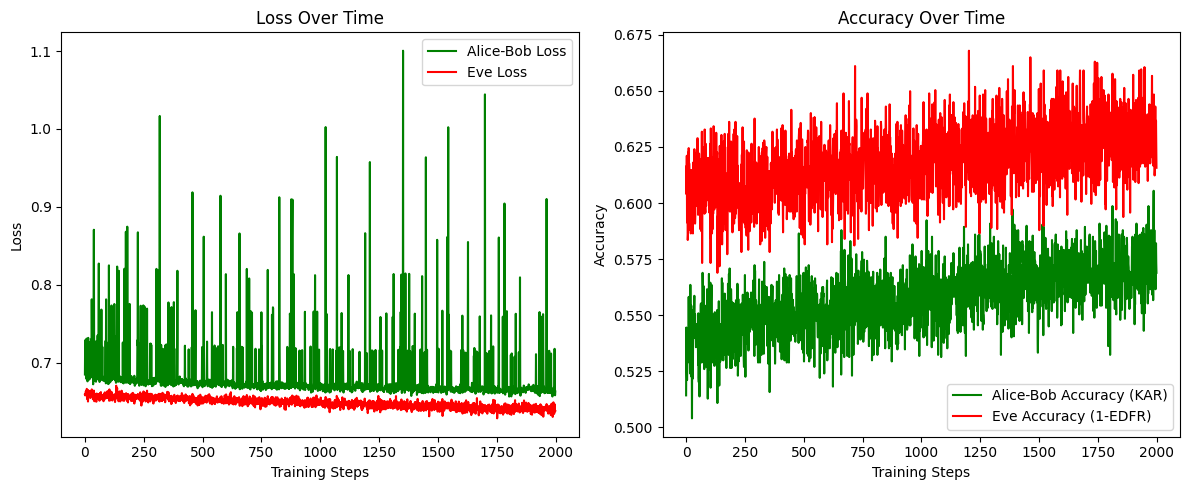

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Hyperparameters
# -------------------------------------------------------
contract_length = 32
key_length = 32
batch_size = 64          # Use a mini-batch for stable training
pretrain_epochs = 1000   # Pretraining epochs (can tune)
main_epochs = 2000       # Joint training epochs (can tune)
noise_base = 0.05        # Base noise scale
noise_scale_var = 0.1    # Additional random noise factor
update_eve_every = 5     # Update Eve every N steps in Stage 3

# -------------------------------------------------------
# Generate random batches
# -------------------------------------------------------
def get_random_batch(batch_size, contract_length, key_length):
    """
    Returns (contracts, keys) each of shape [batch_size, length],
    both containing 0/1 floats.
    """
    contracts = torch.randint(0, 2, (batch_size, contract_length)).float()
    keys = torch.randint(0, 2, (batch_size, key_length)).float()
    return contracts, keys

# -------------------------------------------------------
# Models
# -------------------------------------------------------
class AliceBobNet(nn.Module):
    """
    AliceBobNet is used by both Alice (for encryption) and Bob (for decryption).
    """
    def __init__(self):
        super(AliceBobNet, self).__init__()
        # Example: a deeper/wider network than the original
        self.fc1 = nn.Linear(contract_length + key_length, 32 * (contract_length + key_length))
        self.fc2 = nn.Linear(32 * (contract_length + key_length), 16 * (contract_length + key_length))
        self.fc3 = nn.Linear(16 * (contract_length + key_length), 8 * (contract_length + key_length))
        self.fc4 = nn.Linear(8 * (contract_length + key_length), contract_length)
        self.residual = nn.Linear(contract_length + key_length, contract_length)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # A residual path
        residual = torch.sigmoid(self.residual(x))

        # Feed-forward
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        # Combine
        return x + residual

class EveNet(nn.Module):
    """
    EveNet attempts to decrypt the contract without having the key.
    """
    def __init__(self):
        super(EveNet, self).__init__()
        # Slightly deeper Eve
        self.fc1 = nn.Linear(contract_length, 16 * contract_length)
        self.fc2 = nn.Linear(16 * contract_length, 8 * contract_length)
        self.fc3 = nn.Linear(8 * contract_length, contract_length)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

# -------------------------------------------------------
# Initialize
# -------------------------------------------------------
alice_bob = AliceBobNet()
eve = EveNet()

criterion = nn.BCELoss()

optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=0.0005, weight_decay=1e-5)
optimizer_e = optim.AdamW(eve.parameters(), lr=0.0001, weight_decay=1e-5)

# Optional: Schedulers to decay learning rates over time
scheduler_ab = optim.lr_scheduler.StepLR(optimizer_ab, step_size=800, gamma=0.5)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=800, gamma=0.5)

# For tracking
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []

# Helper to compute batch accuracies
def compute_accuracy(predictions, targets):
    """
    predictions, targets: [batch_size, contract_length] with values in [0,1]
    Returns scalar accuracy in [0,1].
    """
    pred_bin = (predictions > 0.5).float()
    correct = (pred_bin == targets).float().mean()
    return correct.item()

# -------------------------------------------------------
# Stage 1: Pretrain Alice-Bob
# -------------------------------------------------------
print("Pretraining Alice-Bob (Stage 1)...")
for epoch in range(pretrain_epochs):
    # 1) Get batch
    contracts, keys = get_random_batch(batch_size, contract_length, key_length)

    # 2) Alice encrypt
    alice_input = torch.cat((contracts, keys), dim=1)  # shape [batch_size, contract_length+key_length]
    encrypted_contract = alice_bob(alice_input)

    # 3) Bob decrypt: cat encrypted_contract with same key
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input).clamp(0, 1)

    # 4) Loss
    loss = criterion(decrypted_contract, contracts)

    # 5) Backprop
    optimizer_ab.zero_grad()
    loss.backward()
    optimizer_ab.step()

    # Step scheduler
    scheduler_ab.step()

    if epoch % 100 == 0:
        acc = compute_accuracy(decrypted_contract, contracts)
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss.item():.4f}, "
              f"Accuracy: {acc*100:.2f}%")

# -------------------------------------------------------
# Stage 2: Pretrain Eve
# -------------------------------------------------------
print("\nPretraining Eve (Stage 2)...")
for epoch in range(pretrain_epochs):
    # 1) Get batch
    contracts, keys = get_random_batch(batch_size, contract_length, key_length)

    # 2) Alice encrypt (no grad for alice_bob)
    with torch.no_grad():
        alice_input = torch.cat((contracts, keys), dim=1)
        encrypted_contract = alice_bob(alice_input)

    # 3) Eve decrypt
    eve_decrypted = eve(encrypted_contract).clamp(0, 1)

    # 4) Loss
    loss = criterion(eve_decrypted, contracts)

    # 5) Backprop
    optimizer_e.zero_grad()
    loss.backward()
    optimizer_e.step()

    # Step scheduler
    scheduler_e.step()

    if epoch % 100 == 0:
        acc_eve = compute_accuracy(eve_decrypted, contracts)
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss.item():.4f}, "
              f"Accuracy Eve: {acc_eve*100:.2f}%")

# -------------------------------------------------------
# Stage 3: Joint Training (Alice-Bob vs Eve)
# -------------------------------------------------------
print("\nJoint Training (Stage 3)...")
for epoch in range(main_epochs):

    # 1) Get batch
    contracts, keys = get_random_batch(batch_size, contract_length, key_length)

    # 2) Alice encrypt
    alice_input = torch.cat((contracts, keys), dim=1)
    encrypted_contract = alice_bob(alice_input)

    # 3) Add noise to ciphertext
    # noise_base + random * noise_scale_var for each batch
    noise_factor = noise_base + torch.rand(1).item() * noise_scale_var
    noise = torch.randn_like(encrypted_contract) * noise_factor
    encrypted_noisy = encrypted_contract + noise

    # 4) Bob decrypt
    bob_input = torch.cat((encrypted_noisy, keys), dim=1)
    decrypted_contract = alice_bob(bob_input).clamp(0, 1)

    # 5) Eve tries to decrypt
    eve_decrypted = eve(encrypted_noisy).clamp(0, 1)

    # 6) Losses
    loss_ab = criterion(decrypted_contract, contracts)  # minimize so Bob is accurate
    loss_e = criterion(eve_decrypted, contracts)        # Eve tries to minimize her own error

    # 7) Zero grads
    optimizer_ab.zero_grad()
    optimizer_e.zero_grad()

    # 8) Backprop
    # a) Always do Alice-Bob
    loss_ab.backward(retain_graph=True)

    # b) Update Eve only every 'update_eve_every' steps
    if epoch % update_eve_every == 0:
        loss_e.backward()

    # 9) Optim Step
    optimizer_ab.step()
    if epoch % update_eve_every == 0:
        optimizer_e.step()

    # optional: step schedulers
    scheduler_ab.step()
    if epoch % update_eve_every == 0:
        scheduler_e.step()

    # 10) Logging
    acc_ab = compute_accuracy(decrypted_contract, contracts)
    acc_e = compute_accuracy(eve_decrypted, contracts)

    # Store for final stats
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())
    accuracies_ab.append(acc_ab)
    accuracies_e.append(acc_e)

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"[Joint] Epoch {epoch}/{main_epochs}, "
              f"Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f}, "
              f"Acc AB: {acc_ab*100:.2f}%, Acc Eve: {acc_e*100:.2f}%")

# -------------------------------------------------------
# Final Stats
# -------------------------------------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)         # Bob's success
EDFR = 100.0 - (100.0 * sum(accuracies_e) / len(accuracies_e))# Eve's failure
print(f"\nFinal Results after joint training:")
print(f"KAR  = {KAR:.2f}% (Bob's Accuracy)")
print(f"EDFR = {EDFR:.2f}% (Eve's Decryption Failure Rate)")

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1) Plot losses
plt.subplot(1, 2, 1)
plt.plot(losses_ab, label='Alice-Bob Loss', c='green')
plt.plot(losses_e, label='Eve Loss', c='red')
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# 2) Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies_ab, label='Alice-Bob Accuracy (KAR)', c='green')
plt.plot(accuracies_e, label='Eve Accuracy (1-EDFR)', c='red')
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[Pretrain AliceBobNet] Epoch 0/2000, Loss: 31.9173
[Pretrain AliceBobNet] Epoch 100/2000, Loss: 19.3143
[Pretrain AliceBobNet] Epoch 200/2000, Loss: 13.0845
[Pretrain AliceBobNet] Epoch 300/2000, Loss: 6.8179
[Pretrain AliceBobNet] Epoch 400/2000, Loss: 3.7692
[Pretrain AliceBobNet] Epoch 500/2000, Loss: 3.7780
[Pretrain AliceBobNet] Epoch 600/2000, Loss: 0.6017
[Pretrain AliceBobNet] Epoch 700/2000, Loss: 3.7356
[Pretrain AliceBobNet] Epoch 800/2000, Loss: 6.8580
[Pretrain AliceBobNet] Epoch 900/2000, Loss: 0.6311
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 6.8884
[Pretrain AliceBobNet] Epoch 1100/2000, Loss: 6.8709
[Pretrain AliceBobNet] Epoch 1200/2000, Loss: 3.7353
[Pretrain AliceBobNet] Epoch 1300/2000, Loss: 3.7620
[Pretrain AliceBobNet] Epoch 1400/2000, Loss: 3.7466
[Pretrain AliceBobNet] Epoch 1500/2000, Loss: 10.0134
[Pretrain AliceBobNet] Epoch 1600/2000, Loss: 6.9017
[Pretrain AliceBobNet] Epoch 1700/2000, Loss: 6.8900
[Pretrain AliceBobNet] Epoch 1800/2000, Loss: 3.7489
[

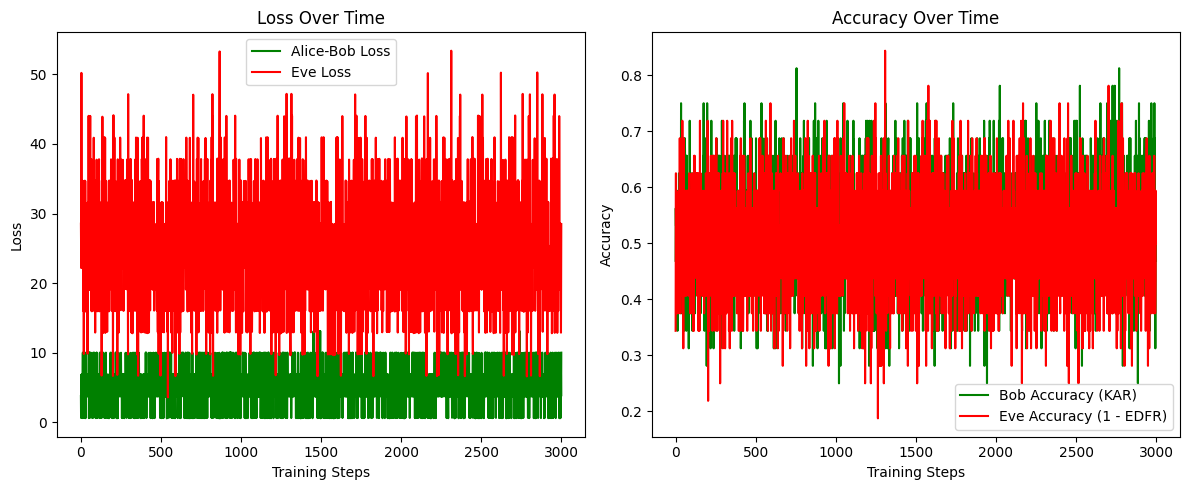

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32
pretrain_epochs = 2000
main_epochs = 3000
lr_ab = 0.0003
lr_e = 0.0001
weight_decay = 1e-4
noise_scale = 0.1  # Max scale for the additive noise

# -------------------------
# Models
# -------------------------
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        self.fc1 = nn.Linear(contract_length + key_length, 32 * (contract_length + key_length))
        self.fc2 = nn.Linear(32 * (contract_length + key_length), 16 * (contract_length + key_length))
        self.fc3 = nn.Linear(16 * (contract_length + key_length), 8 * (contract_length + key_length))
        self.fc4 = nn.Linear(8 * (contract_length + key_length), contract_length)
        self.dropout = nn.Dropout(0.5)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # residual path
        residual_out = torch.sigmoid(self.residual(x))

        # main path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        # add residual
        return x + residual_out


class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        self.fc1 = nn.Linear(contract_length, 16 * contract_length)
        self.fc2 = nn.Linear(16 * contract_length, 8 * contract_length)
        self.fc3 = nn.Linear(8 * contract_length, contract_length)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.sigmoid(self.fc3(x)))
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet()
eve = EveNet()

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Metrics Lists
# -------------------------
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []


# ===========================================================
#  Stage 1: Pretrain AliceBobNet
# ===========================================================
for epoch in range(pretrain_epochs):
    # Fake contracts & keys
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    # Alice-Bob encryption -> decryption
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted_contract = alice_bob(ab_input)

    # Decrypt with the same net (Bob’s perspective)
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)
    decrypted_contract_clamped = torch.clamp(decrypted_contract, 0.0, 1.0)

    loss_ab = criterion(decrypted_contract_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 100 == 0:
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ==================================
# Stage 2: Pretrain EveNet
# ==================================
for epoch in range(pretrain_epochs):
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    # Encrypt with Alice-Bob (no grad)
    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted_contract = alice_bob(ab_input)

    # Eve tries to decrypt
    eve_output = eve(encrypted_contract)
    eve_output_clamped = torch.clamp(eve_output, 0.0, 1.0)

    loss_e = criterion(eve_output_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    if epoch % 100 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e.item():.4f}")


# ==================================
# Stage 3: Joint Training (Two-Pass)
# ==================================
for epoch in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob
    # --------------------------------------------------------
    contracts = torch.randint(0, 2, (1, contract_length)).float()
    keys = torch.randint(0, 2, (1, key_length)).float()

    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    # Add some noise
    noise = torch.randn_like(encrypted) * (torch.rand(1).item() * noise_scale)
    encrypted_noisy = encrypted + noise

    # Bob decrypts
    bob_input = torch.cat((encrypted_noisy, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)

    loss_ab = criterion(bob_decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    # Evaluate Bob’s accuracy on this pass
    bob_dec_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab = torch.mean((bob_dec_binary == contracts).float()).item()

    # --------------------------------------------------------
    # Pass 2: Train Eve (we freeze AB’s weights by default
    # because we won't call optimizer_ab, and we do a new forward pass)
    # --------------------------------------------------------
    # We do a fresh pass so the autograd graph is new (no retain_graph needed).
    with torch.no_grad():
        # Recompute encryption for Eve with the same data
        # (you can reuse the same noise if you like, or generate new noise)
        encrypted2 = alice_bob(ab_input)  # fresh pass
        encrypted2_noisy = encrypted2 + noise  # same noise or new noise

    eve_decrypted = eve(encrypted2_noisy)
    eve_decrypted_clamped = torch.clamp(eve_decrypted, 0.0, 1.0)

    loss_e = criterion(eve_decrypted_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    # Evaluate Eve’s accuracy on this pass
    eve_dec_binary = (eve_decrypted_clamped > 0.5).float()
    acc_e = torch.mean((eve_dec_binary == contracts).float()).item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())
    accuracies_ab.append(acc_ab)
    accuracies_e.append(acc_e)

    if epoch % 100 == 0:
        print(f"[Joint Training] Epoch {epoch}/{main_epochs} | "
              f"Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f} | "
              f"Acc AB: {acc_ab:.4f}, Acc E: {acc_e:.4f}")


# -------------------------
# Final KAR & EDFR
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)      # Bob's average accuracy
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))  # Eve's Decryption Failure Rate

print(f"\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 5))

# 1) Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses_ab)), losses_ab, label='Alice-Bob Loss', color='green')
plt.plot(range(len(losses_e)), losses_e, label='Eve Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# 2) Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_ab)), accuracies_ab, label='Bob Accuracy (KAR)', color='green')
plt.plot(range(len(accuracies_e)), accuracies_e, label='Eve Accuracy (1 - EDFR)', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[Pretrain AliceBobNet] Epoch 0/2000, Loss: 30.5064
[Pretrain AliceBobNet] Epoch 200/2000, Loss: 0.6987
[Pretrain AliceBobNet] Epoch 400/2000, Loss: 0.6944
[Pretrain AliceBobNet] Epoch 600/2000, Loss: 0.6911
[Pretrain AliceBobNet] Epoch 800/2000, Loss: 0.6872
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 0.6875
[Pretrain AliceBobNet] Epoch 1200/2000, Loss: 0.6712
[Pretrain AliceBobNet] Epoch 1400/2000, Loss: 0.6278
[Pretrain AliceBobNet] Epoch 1600/2000, Loss: 0.6808
[Pretrain AliceBobNet] Epoch 1800/2000, Loss: 0.6925
[Pretrain EveNet] Epoch 0/2000, Loss: 0.6949
[Pretrain EveNet] Epoch 200/2000, Loss: 0.6786
[Pretrain EveNet] Epoch 400/2000, Loss: 0.6679
[Pretrain EveNet] Epoch 600/2000, Loss: 0.6526
[Pretrain EveNet] Epoch 800/2000, Loss: 0.6555
[Pretrain EveNet] Epoch 1000/2000, Loss: 0.6487
[Pretrain EveNet] Epoch 1200/2000, Loss: 0.6341
[Pretrain EveNet] Epoch 1400/2000, Loss: 0.6280
[Pretrain EveNet] Epoch 1600/2000, Loss: 0.6303
[Pretrain EveNet] Epoch 1800/2000, Loss: 0.6177
[Jo

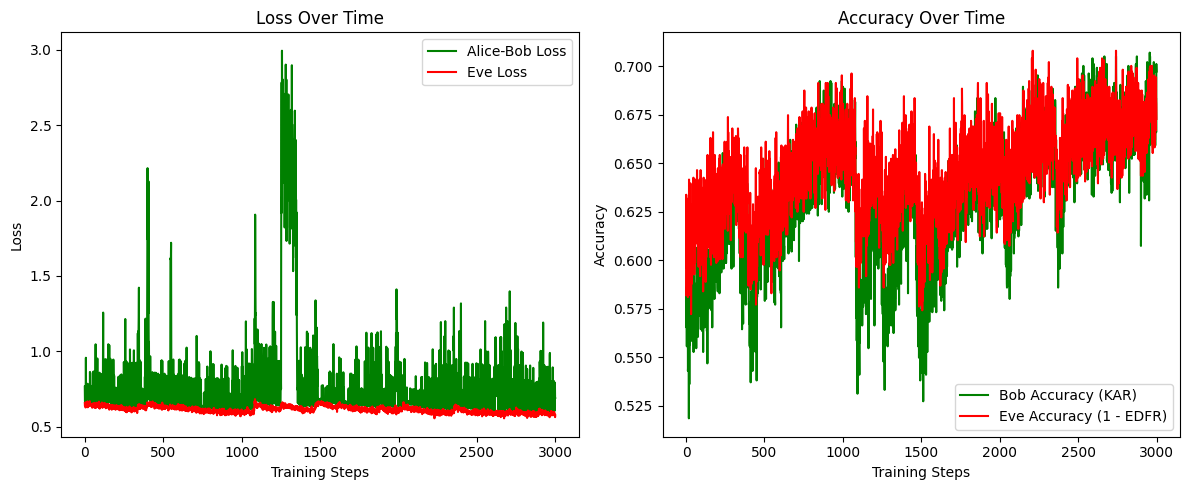

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32
pretrain_epochs = 2000
main_epochs = 3000

batch_size = 32         # train in batches
lr_ab = 0.0003
lr_e = 0.0001
weight_decay = 1e-4

noise_scale_bob = 0.1   # scale for Bob's noise
noise_scale_eve = 0.2   # additional noise scale for Eve
alpha = 0.1             # small adversarial factor for AB’s objective

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# Models
# -------------------------
class AliceBobNet(nn.Module):
    """
    A larger-capacity network for Alice-Bob.
    We significantly increase layer sizes to create a
    more complex transform that might be harder for Eve.
    """
    def __init__(self):
        super(AliceBobNet, self).__init__()
        hidden1 = 64 * (contract_length + key_length)
        hidden2 = 32 * (contract_length + key_length)
        hidden3 = 16 * (contract_length + key_length)

        self.fc1 = nn.Linear(contract_length + key_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, contract_length)

        self.dropout = nn.Dropout(0.3)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # Residual path
        residual_out = torch.sigmoid(self.residual(x))

        # Main path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x + residual_out


class EveNet(nn.Module):
    """
    We keep Eve's capacity somewhat modest so that
    Alice-Bob might "outrun" Eve if well-trained.
    """
    def __init__(self):
        super(EveNet, self).__init__()
        hidden1 = 16 * contract_length
        hidden2 = 8 * contract_length

        self.fc1 = nn.Linear(contract_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, contract_length)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # removing dropout here for final
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet().to(device)
eve = EveNet().to(device)

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Stats Tracking
# -------------------------
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []


# ===========================================================
#  Utility: get a batch of random (contracts, keys)
# ===========================================================
def get_batch(batch_size, contract_len, key_len, device):
    contracts = torch.randint(0, 2, (batch_size, contract_len), device=device).float()
    keys = torch.randint(0, 2, (batch_size, key_len), device=device).float()
    return contracts, keys


# ===========================================================
#  Stage 1: Pretrain AliceBobNet
# ===========================================================
for epoch in range(pretrain_epochs):
    # Get a batch
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # Forward
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)
    bob_input = torch.cat((encrypted, keys), dim=1)
    decrypted = alice_bob(bob_input)
    decrypted_clamped = torch.clamp(decrypted, 0.0, 1.0)

    # Loss
    loss_ab = criterion(decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 200 == 0:  # print less frequently for a bigger batch
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ==================================
# Stage 2: Pretrain EveNet
# ==================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # Encrypt with Alice-Bob (no grad for AB)
    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted = alice_bob(ab_input)

    # Eve tries to decrypt
    eve_output = eve(encrypted)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)

    loss_e = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    if epoch % 200 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e.item():.4f}")


# ==================================
# Stage 3: Joint Training (Two-Pass)
# ==================================
for epoch in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob
    # --------------------------------------------------------
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # Alice-Bob encrypt
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    # Noise for Bob
    noise_bob = torch.randn_like(encrypted) * (torch.rand(1, device=device).item() * noise_scale_bob)
    encrypted_bob = encrypted + noise_bob

    # Bob decrypts
    bob_input = torch.cat((encrypted_bob, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)
    loss_ab = criterion(bob_decrypted_clamped, contracts)

    # -- We also compute Eve's output *in the same pass*
    #    so that AB can "adversarially" consider Eve's error.
    with torch.no_grad():
        # We'll apply extra noise for Eve
        noise_eve = torch.randn_like(encrypted) * noise_scale_eve
        encrypted_eve = encrypted + noise_bob + noise_eve
        eve_decrypted = eve(encrypted_eve)
        eve_decrypted_clamped = torch.clamp(eve_decrypted, 0.0, 1.0)
        loss_e_for_ab = criterion(eve_decrypted_clamped, contracts)

    # Combined adversarial objective for AB:
    # AB wants to minimize its own loss, AND maximize Eve's loss.
    # We approximate that by subtracting alpha * Eve's loss.
    loss_ab_adv = loss_ab - alpha * loss_e_for_ab

    optimizer_ab.zero_grad()
    loss_ab_adv.backward()
    optimizer_ab.step()

    # Evaluate Bob’s accuracy
    bob_dec_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab = (bob_dec_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Pass 2: Train Eve (fresh pass, no retain_graph needed)
    # --------------------------------------------------------
    with torch.no_grad():
        # Recompute encryption for Eve on the same batch
        # plus the same noise or new noise. We'll keep it the same for consistency.
        ab_input_2 = torch.cat((contracts, keys), dim=1)
        encrypted2 = alice_bob(ab_input_2)

        # same bob noise + extra eve noise:
        encrypted2_for_eve = encrypted2 + noise_bob + noise_eve

    eve_output = eve(encrypted2_for_eve)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)
    loss_e = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    # Evaluate Eve’s accuracy
    eve_binary = (eve_clamped > 0.5).float()
    acc_e = (eve_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())
    accuracies_ab.append(acc_ab)
    accuracies_e.append(acc_e)

    if epoch % 100 == 0:
        print(f"[Joint Training] Epoch {epoch}/{main_epochs} | "
              f"Loss AB (no adv): {loss_ab.item():.4f} "
              f"(AB adv - alpha*Eve): {loss_ab_adv.item():.4f}, "
              f"Loss E: {loss_e.item():.4f} | "
              f"Acc AB: {acc_ab:.4f}, Acc E: {acc_e:.4f}")


# -------------------------
# Final KAR & EDFR
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)  # Bob's average accuracy
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))

print(f"\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 5))

# 1) Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses_ab)), losses_ab, label='Alice-Bob Loss', color='green')
plt.plot(range(len(losses_e)), losses_e, label='Eve Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# 2) Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_ab)), accuracies_ab, label='Bob Accuracy (KAR)', color='green')
plt.plot(range(len(accuracies_e)), accuracies_e, label='Eve Accuracy (1 - EDFR)', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[Pretrain AliceBobNet] Epoch 0/2000, Loss: 28.9539
[Pretrain AliceBobNet] Epoch 200/2000, Loss: 0.7059
[Pretrain AliceBobNet] Epoch 400/2000, Loss: 0.7708
[Pretrain AliceBobNet] Epoch 600/2000, Loss: 0.6377
[Pretrain AliceBobNet] Epoch 800/2000, Loss: 0.8319
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 0.6663
[Pretrain AliceBobNet] Epoch 1200/2000, Loss: 0.9578
[Pretrain AliceBobNet] Epoch 1400/2000, Loss: 0.7786
[Pretrain AliceBobNet] Epoch 1600/2000, Loss: 0.9482
[Pretrain AliceBobNet] Epoch 1800/2000, Loss: 0.9399
[Pretrain EveNet] Epoch 0/2000, Loss: 0.6946
[Pretrain EveNet] Epoch 200/2000, Loss: 0.6656
[Pretrain EveNet] Epoch 400/2000, Loss: 0.6232
[Pretrain EveNet] Epoch 600/2000, Loss: 0.5892
[Pretrain EveNet] Epoch 800/2000, Loss: 0.5796
[Pretrain EveNet] Epoch 1000/2000, Loss: 0.5936
[Pretrain EveNet] Epoch 1200/2000, Loss: 0.5667
[Pretrain EveNet] Epoch 1400/2000, Loss: 0.5754
[Pretrain EveNet] Epoch 1600/2000, Loss: 0.5667
[Pretrain EveNet] Epoch 1800/2000, Loss: 0.5632
[Jo

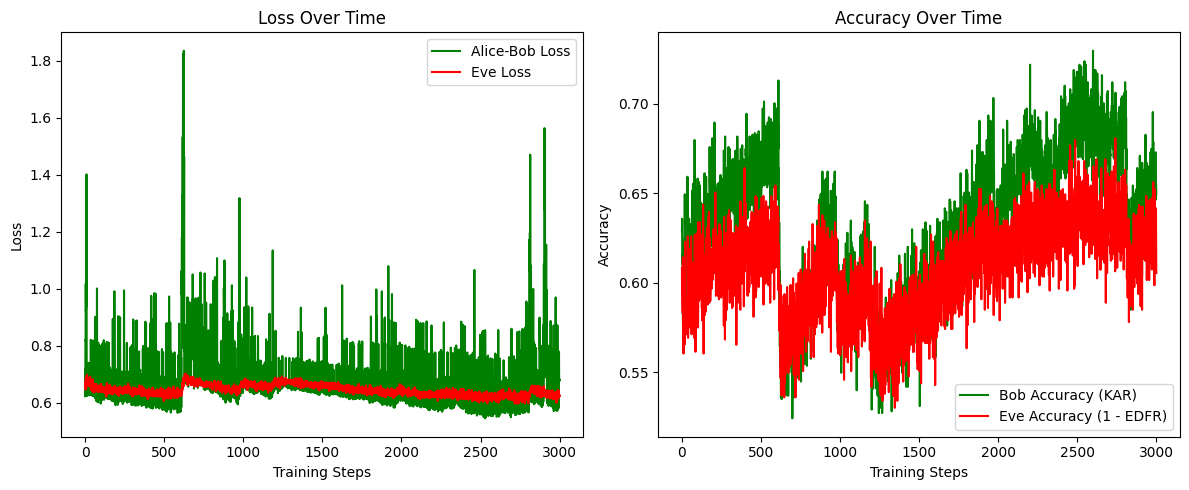

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32

pretrain_epochs = 2000
main_epochs = 3000
batch_size = 32

# Learning rates and weight decay
lr_ab = 0.0003
lr_e = 0.0001
weight_decay = 1e-4

# Noise scales
noise_scale_bob = 0.1   # moderate noise for Bob
noise_scale_eve = 0.3   # bigger noise for Eve

# Probability of random bit flips for Eve
eve_bitflip_prob = 0.05  # 5% random bits flipped in ciphertext

# Adversarial factor
alpha = 0.5  # Larger alpha → Alice-Bob tries harder to worsen Eve’s loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# Models
# -------------------------
class AliceBobNet(nn.Module):
    """
    Larger-capacity network for Alice-Bob.
    """
    def __init__(self):
        super(AliceBobNet, self).__init__()
        hidden1 = 64 * (contract_length + key_length)
        hidden2 = 32 * (contract_length + key_length)
        hidden3 = 16 * (contract_length + key_length)

        self.fc1 = nn.Linear(contract_length + key_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, contract_length)

        self.dropout = nn.Dropout(0.3)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # Residual path
        residual_out = torch.sigmoid(self.residual(x))

        # Main path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x + residual_out


class EveNet(nn.Module):
    """
    A relatively smaller net for Eve.
    """
    def __init__(self):
        super(EveNet, self).__init__()
        hidden1 = 16 * contract_length
        hidden2 = 8 * contract_length

        self.fc1 = nn.Linear(contract_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, contract_length)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # final output
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet().to(device)
eve = EveNet().to(device)

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Tracking
# -------------------------
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []


# -------------------------
# Utility function for batches
# -------------------------
def get_batch(batch_size, contract_len, key_len, device):
    contracts = torch.randint(0, 2, (batch_size, contract_len), device=device).float()
    keys = torch.randint(0, 2, (batch_size, key_len), device=device).float()
    return contracts, keys

def random_bitflip(x, flip_prob):
    """
    Randomly flips bits in x with probability `flip_prob`.
    x is a float in [0,1]. We'll treat >0.5 as 'bit=1', else 'bit=0'.
    Then flip some fraction of bits,
    and map back to 0/1 float.
    """
    # Convert to 0/1
    bit_vals = (x > 0.5).float()
    # Generate mask of flips
    flip_mask = (torch.rand_like(bit_vals) < flip_prob).float()
    # XOR to flip bits
    flipped = (bit_vals + flip_mask) % 2.0
    # Return as float in {0,1}
    return flipped


# ===========================================================
#  Stage 1: Pretrain AliceBobNet
# ===========================================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)
    bob_input = torch.cat((encrypted, keys), dim=1)
    decrypted = alice_bob(bob_input)
    decrypted_clamped = torch.clamp(decrypted, 0.0, 1.0)

    loss_ab = criterion(decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 200 == 0:
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ==================================
# Stage 2: Pretrain EveNet
# ==================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted = alice_bob(ab_input)

    eve_output = eve(encrypted)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)
    loss_e = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    if epoch % 200 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e.item():.4f}")


# ==================================
# Stage 3: Joint Training (Two-Pass, with extra noise & bit flips)
# ==================================
for epoch in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob with adversarial objective
    # --------------------------------------------------------
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # 1) Encrypt with AB
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)  # shape: [batch_size, contract_length]

    # 2) Add moderate noise for Bob
    random_scale = torch.rand((batch_size, 1), device=device) * noise_scale_bob
    noise_bob = torch.randn_like(encrypted) * random_scale
    encrypted_bob = torch.clamp(encrypted + noise_bob, 0.0, 1.0)

    # 3) Bob decrypt
    bob_input = torch.cat((encrypted_bob, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)
    loss_ab = criterion(bob_decrypted_clamped, contracts)

    # -- Evaluate Eve's output in the same pass (no_grad),
    #    but with bigger noise + random bit flips
    with torch.no_grad():
        # bigger Eve noise
        noise_eve = torch.randn_like(encrypted) * noise_scale_eve
        encrypted_for_eve = encrypted + noise_eve
        # clamp to [0,1]
        encrypted_for_eve = torch.clamp(encrypted_for_eve, 0.0, 1.0)
        # random bit flips
        flipped_bits = random_bitflip(encrypted_for_eve, eve_bitflip_prob)

        eve_decrypted_tmp = eve(flipped_bits)
        eve_decrypted_clamped = torch.clamp(eve_decrypted_tmp, 0.0, 1.0)
        loss_e_for_ab = criterion(eve_decrypted_clamped, contracts)

    # Combined adversarial objective:
    #  minimize Bob’s loss, maximize Eve’s loss => subtract alpha * Eve’s loss
    loss_ab_adv = loss_ab - alpha * loss_e_for_ab

    optimizer_ab.zero_grad()
    loss_ab_adv.backward()
    optimizer_ab.step()

    # Evaluate Bob’s accuracy
    bob_dec_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab = (bob_dec_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Pass 2: Train Eve (fresh forward pass, no retain_graph)
    # --------------------------------------------------------
    with torch.no_grad():
        # Recompute encryption
        ab_input_2 = torch.cat((contracts, keys), dim=1)
        encrypted2 = alice_bob(ab_input_2)

        noise_eve2 = torch.randn_like(encrypted2) * noise_scale_eve
        encrypted_for_eve2 = torch.clamp(encrypted2 + noise_eve2, 0.0, 1.0)
        # flip bits
        flipped_bits2 = random_bitflip(encrypted_for_eve2, eve_bitflip_prob)

    eve_output2 = eve(flipped_bits2)
    eve_clamped2 = torch.clamp(eve_output2, 0.0, 1.0)
    loss_e = criterion(eve_clamped2, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    # Evaluate Eve’s accuracy
    eve_binary = (eve_clamped2 > 0.5).float()
    acc_e = (eve_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())
    accuracies_ab.append(acc_ab)
    accuracies_e.append(acc_e)

    if epoch % 100 == 0:
        print(f"[Joint Training] Epoch {epoch}/{main_epochs} | "
              f"Loss AB(no adv): {loss_ab.item():.4f}, "
              f"Loss AB(adv): {loss_ab_adv.item():.4f}, "
              f"Loss E: {loss_e.item():.4f} | "
              f"Acc AB: {acc_ab:.4f}, Acc E: {acc_e:.4f}")


# -------------------------
# Final KAR & EDFR
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)      # Bob's average accuracy
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))  # 100 - Eve's avg accuracy in %

print(f"\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 5))

# 1) Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses_ab)), losses_ab, label='Alice-Bob Loss', color='green')
plt.plot(range(len(losses_e)), losses_e, label='Eve Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# 2) Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_ab)), accuracies_ab, label='Bob Accuracy (KAR)', color='green')
plt.plot(range(len(accuracies_e)), accuracies_e, label='Eve Accuracy (1 - EDFR)', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[Pretrain AliceBobNet] Epoch 0/2000, Loss: 23.2727
[Pretrain AliceBobNet] Epoch 500/2000, Loss: 2.0404
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 2.5246
[Pretrain AliceBobNet] Epoch 1500/2000, Loss: 2.0308
[Pretrain EveNet] Epoch 0/2000, Loss: 0.6929
[Pretrain EveNet] Epoch 500/2000, Loss: 0.6900
[Pretrain EveNet] Epoch 1000/2000, Loss: 0.6845
[Pretrain EveNet] Epoch 1500/2000, Loss: 0.6779
[Joint Training] Epoch 0/4000 | Loss AB(no adv): 2.5167, Loss AB(adv): 1.8047, Loss E: 0.7216 | Acc AB: 0.5654, Acc E: 0.5234
[Joint Training] Epoch 100/4000 | Loss AB(no adv): 2.1243, Loss AB(adv): 1.4356, Loss E: 0.6932 | Acc AB: 0.5723, Acc E: 0.5283
[Joint Training] Epoch 200/4000 | Loss AB(no adv): 2.0249, Loss AB(adv): 1.3299, Loss E: 0.6948 | Acc AB: 0.5781, Acc E: 0.5029
[Joint Training] Epoch 300/4000 | Loss AB(no adv): 2.2193, Loss AB(adv): 1.5284, Loss E: 0.6958 | Acc AB: 0.5771, Acc E: 0.4883
[Joint Training] Epoch 400/4000 | Loss AB(no adv): 2.2154, Loss AB(adv): 1.5253, Loss E: 0.69

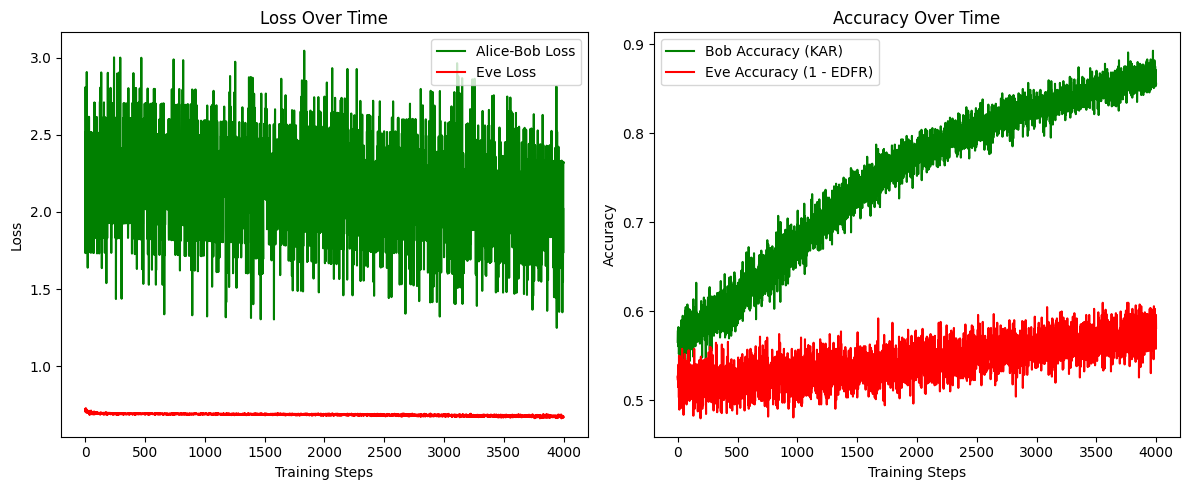

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32

pretrain_epochs = 2000
main_epochs = 4000  # train longer for higher KAR
batch_size = 32

# Learning rates and weight decay
lr_ab = 0.0003
lr_e = 0.0001
weight_decay = 1e-4

# Noise scales
noise_scale_bob = 0.01   # minimal noise for Bob
noise_scale_eve = 0.4    # bigger noise for Eve

# Probability of random bit flips for Eve
eve_bitflip_prob = 0.20  # 20% random flips in ciphertext for Eve

# Adversarial factor
alpha = 1.0  # Strongly push AB to sabotage Eve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# Models
# -------------------------
class AliceBobNet(nn.Module):
    """
    Very large capacity for Alice-Bob.
    We want Bob to have a big advantage in modeling complex transformations.
    """
    def __init__(self):
        super(AliceBobNet, self).__init__()
        hidden1 = 128 * (contract_length + key_length)
        hidden2 = 64 * (contract_length + key_length)
        hidden3 = 32 * (contract_length + key_length)

        self.fc1 = nn.Linear(contract_length + key_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, contract_length)

        self.dropout = nn.Dropout(0.4)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # Residual path
        residual_out = torch.sigmoid(self.residual(x))

        # Main path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x + residual_out


class EveNet(nn.Module):
    """
    Very small capacity for Eve.
    This makes it harder for Eve to learn the inversion.
    """
    def __init__(self):
        super(EveNet, self).__init__()
        hidden1 = 4 * contract_length  # drastically smaller
        hidden2 = 2 * contract_length

        self.fc1 = nn.Linear(contract_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, contract_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet().to(device)
eve = EveNet().to(device)

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Lists for tracking metrics
# -------------------------
losses_ab, losses_e = [], []
accuracies_ab, accuracies_e = [], []


# -------------------------
# Utility: get a batch
# -------------------------
def get_batch(batch_size, contract_len, key_len, device):
    contracts = torch.randint(0, 2, (batch_size, contract_len), device=device).float()
    keys = torch.randint(0, 2, (batch_size, key_len), device=device).float()
    return contracts, keys

def random_bitflip(x, flip_prob):
    """
    Randomly flips bits in x with probability `flip_prob`.
    We'll treat >0.5 as '1' and <=0.5 as '0'.
    """
    bit_vals = (x > 0.5).float()
    flip_mask = (torch.rand_like(bit_vals) < flip_prob).float()
    flipped = (bit_vals + flip_mask) % 2.0
    return flipped


# ===========================================================
#  Stage 1: Pretrain AliceBobNet
# ===========================================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)
    bob_input = torch.cat((encrypted, keys), dim=1)
    decrypted = alice_bob(bob_input)
    decrypted_clamped = torch.clamp(decrypted, 0.0, 1.0)

    loss_ab = criterion(decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 500 == 0:
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ==================================
# Stage 2: Pretrain EveNet
# ==================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted = alice_bob(ab_input)

    eve_output = eve(encrypted)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)
    loss_e = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    if epoch % 500 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e.item():.4f}")


# ==================================
# Stage 3: Joint Training
# ==================================
for epoch in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob (Adversarially)
    # --------------------------------------------------------
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # 1) Encrypt
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    # 2) Very small noise for Bob
    random_scale = torch.rand((batch_size, 1), device=device) * noise_scale_bob
    noise_bob = torch.randn_like(encrypted) * random_scale
    encrypted_bob = torch.clamp(encrypted + noise_bob, 0, 1)

    # 3) Bob decrypt
    bob_input = torch.cat((encrypted_bob, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)
    loss_ab = criterion(bob_decrypted_clamped, contracts)

    # 4) Evaluate Eve’s loss (no_grad)
    with torch.no_grad():
        # bigger noise + random bit flips for Eve
        noise_eve = torch.randn_like(encrypted) * noise_scale_eve
        encrypted_eve = torch.clamp(encrypted + noise_eve, 0, 1)
        flipped_eve = random_bitflip(encrypted_eve, eve_bitflip_prob)

        eve_decrypted_tmp = eve(flipped_eve)
        eve_decrypted_clamped = torch.clamp(eve_decrypted_tmp, 0.0, 1.0)
        loss_e_for_ab = criterion(eve_decrypted_clamped, contracts)

    # Adversarial objective
    loss_ab_adv = loss_ab - alpha * loss_e_for_ab

    optimizer_ab.zero_grad()
    loss_ab_adv.backward()
    optimizer_ab.step()

    # Bob’s accuracy
    bob_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab = (bob_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Pass 2: Train Eve
    # --------------------------------------------------------
    with torch.no_grad():
        # Recompute encryption
        ab_input2 = torch.cat((contracts, keys), dim=1)
        encrypted2 = alice_bob(ab_input2)
        # bigger noise + flips
        noise_eve2 = torch.randn_like(encrypted2) * noise_scale_eve
        encrypted_eve2 = torch.clamp(encrypted2 + noise_eve2, 0, 1)
        flipped_eve2 = random_bitflip(encrypted_eve2, eve_bitflip_prob)

    eve_output2 = eve(flipped_eve2)
    eve_clamped2 = torch.clamp(eve_output2, 0, 1)
    loss_e = criterion(eve_clamped2, contracts)

    optimizer_e.zero_grad()
    loss_e.backward()
    optimizer_e.step()

    # Eve’s accuracy
    eve_binary = (eve_clamped2 > 0.5).float()
    acc_e = (eve_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab.item())
    losses_e.append(loss_e.item())
    accuracies_ab.append(acc_ab)
    accuracies_e.append(acc_e)

    if epoch % 100 == 0:
        print(f"[Joint Training] Epoch {epoch}/{main_epochs} | "
              f"Loss AB(no adv): {loss_ab.item():.4f}, "
              f"Loss AB(adv): {loss_ab_adv.item():.4f}, "
              f"Loss E: {loss_e.item():.4f} | "
              f"Acc AB: {acc_ab:.4f}, Acc E: {acc_e:.4f}")


# -------------------------
# Final KAR & EDFR
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)      # Bob's average accuracy
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))  # 100 - Eve’s avg accuracy

print(f"\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 5))

# 1) Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(losses_ab)), losses_ab, label='Alice-Bob Loss', color='green')
plt.plot(range(len(losses_e)), losses_e, label='Eve Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# 2) Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_ab)), accuracies_ab, label='Bob Accuracy (KAR)', color='green')
plt.plot(range(len(accuracies_e)), accuracies_e, label='Eve Accuracy (1 - EDFR)', color='red')
plt.title('Accuracy Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[Pretrain AliceBobNet] Epoch 0/2000, Loss: 30.5956
[Pretrain AliceBobNet] Epoch 500/2000, Loss: 1.7534
[Pretrain AliceBobNet] Epoch 1000/2000, Loss: 2.1317
[Pretrain AliceBobNet] Epoch 1500/2000, Loss: 2.3232
[Pretrain EveNet] Epoch 0/2000, Loss: 0.6947
[Pretrain EveNet] Epoch 500/2000, Loss: 0.6884
[Pretrain EveNet] Epoch 1000/2000, Loss: 0.6802
[Pretrain EveNet] Epoch 1500/2000, Loss: 0.6638
[Joint] Epoch 0/4000 | Loss AB(no adv): 2.2108, Loss AB(adv): 1.4847, Loss E: 0.7319 | Acc AB: 0.6299, Acc E: 0.5039
[Joint] Epoch 100/4000 | Loss AB(no adv): 2.4955, Loss AB(adv): 1.8016, Loss E: 0.6963 | Acc AB: 0.6865, Acc E: 0.5195
[Joint] Epoch 200/4000 | Loss AB(no adv): 2.2099, Loss AB(adv): 1.5127, Loss E: 0.6909 | Acc AB: 0.6494, Acc E: 0.5303
[Joint] Epoch 300/4000 | Loss AB(no adv): 2.0052, Loss AB(adv): 1.3126, Loss E: 0.6919 | Acc AB: 0.6924, Acc E: 0.5088
[Joint] Epoch 400/4000 | Loss AB(no adv): 2.0982, Loss AB(adv): 1.4046, Loss E: 0.6904 | Acc AB: 0.7227, Acc E: 0.5225
[Joint] Ep

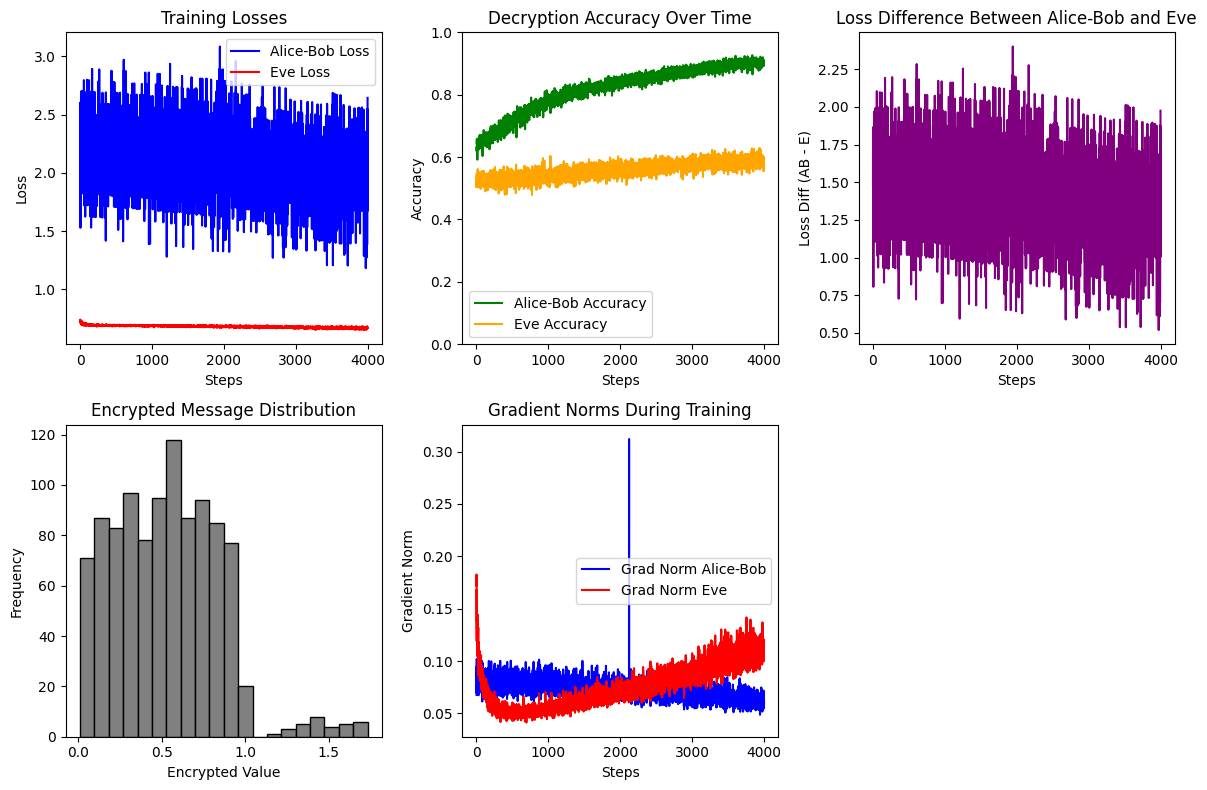

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32

pretrain_epochs = 2000
main_epochs = 4000  # train longer for higher KAR
batch_size = 32

# Learning rates and weight decay
lr_ab = 0.0003
lr_e = 0.0001
weight_decay = 1e-4

# Noise scales
noise_scale_bob = 0.01   # minimal noise for Bob
noise_scale_eve = 0.4    # bigger noise for Eve

# Probability of random bit flips for Eve
eve_bitflip_prob = 0.20  # 20% random flips in ciphertext for Eve

# Adversarial factor
alpha = 1.0  # Strongly push AB to sabotage Eve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# Models
# -------------------------
class AliceBobNet(nn.Module):
    """
    Very large capacity for Alice-Bob.
    We want Bob to have a big advantage in modeling complex transformations.
    """
    def __init__(self):
        super(AliceBobNet, self).__init__()
        hidden1 = 128 * (contract_length + key_length)
        hidden2 = 64 * (contract_length + key_length)
        hidden3 = 32 * (contract_length + key_length)

        self.fc1 = nn.Linear(contract_length + key_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, contract_length)

        self.dropout = nn.Dropout(0.4)
        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # Residual path
        residual_out = torch.sigmoid(self.residual(x))

        # Main path
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x + residual_out


class EveNet(nn.Module):
    """
    Very small capacity for Eve.
    This makes it harder for Eve to learn the inversion.
    """
    def __init__(self):
        super(EveNet, self).__init__()
        hidden1 = 4 * contract_length  # drastically smaller
        hidden2 = 2 * contract_length

        self.fc1 = nn.Linear(contract_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, contract_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet().to(device)
eve = EveNet().to(device)

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Lists for tracking metrics
# -------------------------
losses_ab = []
losses_e = []
loss_diff = []
accuracies_ab = []
accuracies_e = []
grad_norm_ab_list = []
grad_norm_e_list = []
encrypted_samples = []  # for final histogram of ciphertext

# -------------------------
# Utility: get a batch
# -------------------------
def get_batch(batch_size, contract_len, key_len, device):
    contracts = torch.randint(0, 2, (batch_size, contract_len), device=device).float()
    keys = torch.randint(0, 2, (batch_size, key_len), device=device).float()
    return contracts, keys

def random_bitflip(x, flip_prob):
    """
    Randomly flips bits in x with probability `flip_prob`.
    We'll treat >0.5 as '1' and <=0.5 as '0'.
    """
    bit_vals = (x > 0.5).float()
    flip_mask = (torch.rand_like(bit_vals) < flip_prob).float()
    flipped = (bit_vals + flip_mask) % 2.0
    return flipped


# ===========================================================
# Stage 1: Pretrain AliceBobNet
# ===========================================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    bob_input = torch.cat((encrypted, keys), dim=1)
    decrypted = alice_bob(bob_input)
    decrypted_clamped = torch.clamp(decrypted, 0.0, 1.0)

    loss_ab = criterion(decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 500 == 0:
        print(f"[Pretrain AliceBobNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ==================================
# Stage 2: Pretrain EveNet
# ==================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted = alice_bob(ab_input)

    eve_output = eve(encrypted)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)
    loss_e_pre = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e_pre.backward()
    optimizer_e.step()

    if epoch % 500 == 0:
        print(f"[Pretrain EveNet] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e_pre.item():.4f}")


# ==================================
# Stage 3: Joint Training
# ==================================
for ep in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob (Adversarially)
    # --------------------------------------------------------
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # 1) Encrypt
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    # 2) Very small noise for Bob
    random_scale = torch.rand((batch_size, 1), device=device) * noise_scale_bob
    noise_bob = torch.randn_like(encrypted) * random_scale
    encrypted_bob = torch.clamp(encrypted + noise_bob, 0, 1)

    # 3) Bob decrypt
    bob_input = torch.cat((encrypted_bob, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)
    loss_ab_now = criterion(bob_decrypted_clamped, contracts)

    # 4) Evaluate Eve’s loss (no_grad)
    with torch.no_grad():
        # bigger noise + random bit flips for Eve
        noise_eve = torch.randn_like(encrypted) * noise_scale_eve
        encrypted_eve = torch.clamp(encrypted + noise_eve, 0, 1)
        flipped_eve = random_bitflip(encrypted_eve, eve_bitflip_prob)

        eve_decrypted_tmp = eve(flipped_eve)
        eve_decrypted_clamped = torch.clamp(eve_decrypted_tmp, 0.0, 1.0)
        loss_e_for_ab = criterion(eve_decrypted_clamped, contracts)

    # Adversarial objective
    loss_ab_adv = loss_ab_now - alpha * loss_e_for_ab

    optimizer_ab.zero_grad()
    loss_ab_adv.backward()

    # ---- measure gradient norm for Alice-Bob
    grad_norm_ab = 0.0
    for p in alice_bob.parameters():
        if p.grad is not None:
            grad_norm_ab += p.grad.data.norm(2).item() ** 2
    grad_norm_ab = math.sqrt(grad_norm_ab)

    optimizer_ab.step()

    # Bob’s accuracy
    bob_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab_now = (bob_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Pass 2: Train Eve
    # --------------------------------------------------------
    with torch.no_grad():
        # Recompute encryption
        ab_input2 = torch.cat((contracts, keys), dim=1)
        encrypted2 = alice_bob(ab_input2)
        # bigger noise + flips
        noise_eve2 = torch.randn_like(encrypted2) * noise_scale_eve
        encrypted_eve2 = torch.clamp(encrypted2 + noise_eve2, 0, 1)
        flipped_eve2 = random_bitflip(encrypted_eve2, eve_bitflip_prob)

    eve_output2 = eve(flipped_eve2)
    eve_clamped2 = torch.clamp(eve_output2, 0, 1)
    loss_e_now = criterion(eve_clamped2, contracts)

    optimizer_e.zero_grad()
    loss_e_now.backward()

    # ---- measure gradient norm for Eve
    grad_norm_e = 0.0
    for p in eve.parameters():
        if p.grad is not None:
            grad_norm_e += p.grad.data.norm(2).item() ** 2
    grad_norm_e = math.sqrt(grad_norm_e)

    optimizer_e.step()

    # Eve’s accuracy
    eve_binary = (eve_clamped2 > 0.5).float()
    acc_e_now = (eve_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab_now.item())
    losses_e.append(loss_e_now.item())
    loss_diff.append(loss_ab_now.item() - loss_e_now.item())
    accuracies_ab.append(acc_ab_now)
    accuracies_e.append(acc_e_now)
    grad_norm_ab_list.append(grad_norm_ab)
    grad_norm_e_list.append(grad_norm_e)

    # Collect encrypted samples in the *last* iteration for histogram
    if ep == main_epochs - 1:
        # flatten the ciphertext into a 1-D list
        encrypted_samples.extend(encrypted.detach().cpu().view(-1).tolist())

    if ep % 100 == 0:
        print(f"[Joint] Epoch {ep}/{main_epochs} | "
              f"Loss AB(no adv): {loss_ab_now.item():.4f}, "
              f"Loss AB(adv): {loss_ab_adv.item():.4f}, "
              f"Loss E: {loss_e_now.item():.4f} | "
              f"Acc AB: {acc_ab_now:.4f}, Acc E: {acc_e_now:.4f}")

# -------------------------
# Final KAR & EDFR
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)      # Bob's average accuracy
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))  # 100 - Eve’s avg accuracy

print(f"\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")

# =========================================================
# PLOT:  2 x 3 Subplots
# =========================================================
fig = plt.figure(figsize=(12, 8))

# 1) Training Losses (top-left)
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(losses_ab, label='Alice-Bob Loss', color='blue')
ax1.plot(losses_e, label='Eve Loss', color='red')
ax1.set_title("Training Losses")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.legend()

# 2) Decryption Accuracy Over Time (top-center)
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(accuracies_ab, label='Alice-Bob Accuracy', color='green')
ax2.plot(accuracies_e, label='Eve Accuracy', color='orange')
ax2.set_title("Decryption Accuracy Over Time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

# 3) Loss Difference (AB - Eve) (top-right)
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(loss_diff, color='purple')
ax3.set_title("Loss Difference Between Alice-Bob and Eve")
ax3.set_xlabel("Steps")
ax3.set_ylabel("Loss Diff (AB - E)")

# 4) Encrypted Message Distribution (bottom-left)
ax4 = fig.add_subplot(2, 3, 4)
ax4.hist(encrypted_samples, bins=20, color='gray', edgecolor='black')
ax4.set_title("Encrypted Message Distribution")
ax4.set_xlabel("Encrypted Value")
ax4.set_ylabel("Frequency")

# 5) Gradient Norms During Training (bottom-center)
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(grad_norm_ab_list, label='Grad Norm Alice-Bob', color='blue')
ax5.plot(grad_norm_e_list, label='Grad Norm Eve', color='red')
ax5.set_title("Gradient Norms During Training")
ax5.set_xlabel("Steps")
ax5.set_ylabel("Gradient Norm")
ax5.legend()

# Leave the bottom-right subplot blank or add anything else you want
# If you want an empty subplot:
ax6 = fig.add_subplot(2, 3, 6)
ax6.set_visible(False)

plt.tight_layout()
plt.show()


[Pretrain AB] Epoch 0/2000, Loss: 27.7762
[Pretrain AB] Epoch 500/2000, Loss: 6.7512
[Pretrain AB] Epoch 1000/2000, Loss: 7.2967
[Pretrain AB] Epoch 1500/2000, Loss: 6.8154
[Pretrain Eve] Epoch 0/2000, Loss: 0.6954
[Pretrain Eve] Epoch 500/2000, Loss: 0.6935
[Pretrain Eve] Epoch 1000/2000, Loss: 0.6927
[Pretrain Eve] Epoch 1500/2000, Loss: 0.6901
[Joint] Epoch 0/10000 | Loss AB(no adv): 6.8327, Loss AB(adv): -7.0279, Loss Eve: 0.6919 | Acc AB: 0.8604, Acc Eve: 0.5244
[Joint] Epoch 100/10000 | Loss AB(no adv): 7.0068, Loss AB(adv): -6.8338, Loss Eve: 0.6915 | Acc AB: 0.8447, Acc Eve: 0.5410
[Joint] Epoch 200/10000 | Loss AB(no adv): 5.9130, Loss AB(adv): -7.9892, Loss Eve: 0.6938 | Acc AB: 0.8721, Acc Eve: 0.5000
[Joint] Epoch 300/10000 | Loss AB(no adv): 6.7911, Loss AB(adv): -7.0967, Loss Eve: 0.6952 | Acc AB: 0.8584, Acc Eve: 0.4922
[Joint] Epoch 400/10000 | Loss AB(no adv): 6.2716, Loss AB(adv): -7.6155, Loss Eve: 0.6947 | Acc AB: 0.8809, Acc Eve: 0.4941
[Joint] Epoch 500/10000 | Lo

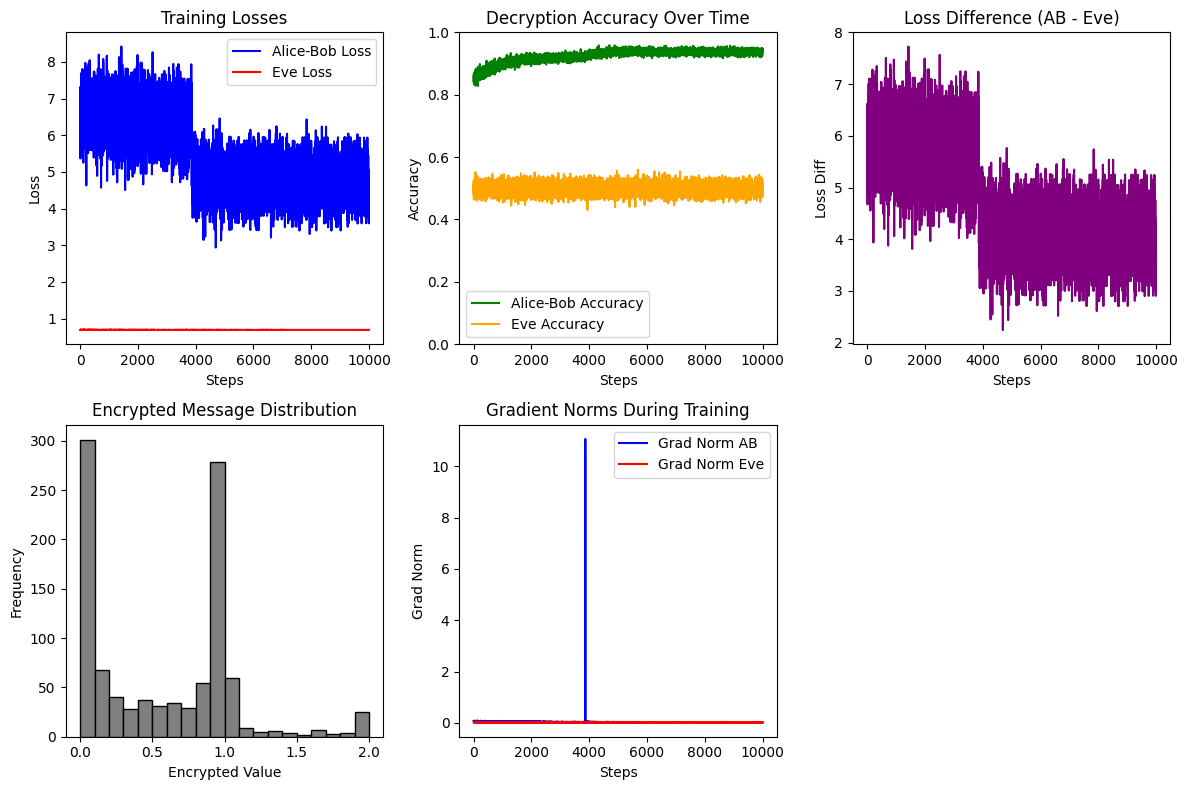

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# -------------------------
# Hyperparameters
# -------------------------
contract_length = 32
key_length = 32

pretrain_epochs = 2000
main_epochs = 10000  # train much longer
batch_size = 32

# Larger LR for AB, smaller LR for Eve
lr_ab = 0.001
lr_e = 0.00001
weight_decay = 0.0  # remove weight decay

# MASSIVE sabotage
noise_scale_bob = 0.0     # keep Bob's signal clean
noise_scale_eve = 5.0     # huge noise for Eve
eve_bitflip_prob = 0.9    # extremely high bitflip
alpha = 20.0              # high adversarial factor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# AliceBobNet: No Dropout
# -------------------------
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        hidden1 = 128 * (contract_length + key_length)
        hidden2 = 64 * (contract_length + key_length)
        hidden3 = 32 * (contract_length + key_length)

        self.fc1 = nn.Linear(contract_length + key_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, contract_length)

        self.residual = nn.Linear(contract_length + key_length, contract_length)

    def forward(self, x):
        # Residual
        residual_out = torch.sigmoid(self.residual(x))
        # Main path
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x + residual_out


# -------------------------
# EveNet: Very Small
# -------------------------
class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        # drastically smaller hidden dims
        hidden1 = 2 * contract_length
        hidden2 = contract_length

        self.fc1 = nn.Linear(contract_length, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, contract_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# -------------------------
# Initialize models
# -------------------------
alice_bob = AliceBobNet().to(device)
eve = EveNet().to(device)

# -------------------------
# Loss and Optimizers
# -------------------------
criterion = nn.BCELoss()
optimizer_ab = optim.AdamW(alice_bob.parameters(), lr=lr_ab, weight_decay=weight_decay)
optimizer_e = optim.AdamW(eve.parameters(), lr=lr_e, weight_decay=weight_decay)

# -------------------------
# Tracking lists
# -------------------------
losses_ab = []
losses_e = []
loss_diff = []
accuracies_ab = []
accuracies_e = []
grad_norm_ab_list = []
grad_norm_e_list = []
encrypted_samples = []  # for histogram at the end


def get_batch(batch_size, contract_len, key_len, device):
    contracts = torch.randint(0, 2, (batch_size, contract_len), device=device).float()
    keys = torch.randint(0, 2, (batch_size, key_len), device=device).float()
    return contracts, keys

def random_bitflip(x, flip_prob):
    """
    Randomly flips bits in x with probability `flip_prob`.
    We'll treat >0.5 as '1' and <=0.5 as '0'.
    """
    bit_vals = (x > 0.5).float()
    flip_mask = (torch.rand_like(bit_vals) < flip_prob).float()
    flipped = (bit_vals + flip_mask) % 2.0
    return flipped


# ===========================================================
# Stage 1: Pretrain Alice-Bob
# ===========================================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    bob_input = torch.cat((encrypted, keys), dim=1)
    decrypted = alice_bob(bob_input)
    decrypted_clamped = torch.clamp(decrypted, 0.0, 1.0)

    loss_ab = criterion(decrypted_clamped, contracts)

    optimizer_ab.zero_grad()
    loss_ab.backward()
    optimizer_ab.step()

    if epoch % 500 == 0:
        print(f"[Pretrain AB] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_ab.item():.4f}")


# ===========================================================
# Stage 2: Pretrain Eve
# ===========================================================
for epoch in range(pretrain_epochs):
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    with torch.no_grad():
        ab_input = torch.cat((contracts, keys), dim=1)
        encrypted = alice_bob(ab_input)

    eve_output = eve(encrypted)
    eve_clamped = torch.clamp(eve_output, 0.0, 1.0)
    loss_e_pre = criterion(eve_clamped, contracts)

    optimizer_e.zero_grad()
    loss_e_pre.backward()
    optimizer_e.step()

    if epoch % 500 == 0:
        print(f"[Pretrain Eve] Epoch {epoch}/{pretrain_epochs}, Loss: {loss_e_pre.item():.4f}")


# ===========================================================
# Stage 3: Joint Training
# ===========================================================
for ep in range(main_epochs):

    # --------------------------------------------------------
    # Pass 1: Train Alice-Bob
    # --------------------------------------------------------
    contracts, keys = get_batch(batch_size, contract_length, key_length, device)

    # 1) Encrypt
    ab_input = torch.cat((contracts, keys), dim=1)
    encrypted = alice_bob(ab_input)

    # 2) Bob sees no noise
    if noise_scale_bob > 0:
        noise_bob = torch.randn_like(encrypted) * noise_scale_bob
        encrypted_bob = torch.clamp(encrypted + noise_bob, 0, 1)
    else:
        encrypted_bob = encrypted

    # 3) Bob decrypt
    bob_input = torch.cat((encrypted_bob, keys), dim=1)
    bob_decrypted = alice_bob(bob_input)
    bob_decrypted_clamped = torch.clamp(bob_decrypted, 0.0, 1.0)
    loss_ab_now = criterion(bob_decrypted_clamped, contracts)

    # 4) Evaluate Eve's loss (no_grad) for adversarial objective
    with torch.no_grad():
        noise_eve_tensor = torch.randn_like(encrypted) * noise_scale_eve
        encrypted_eve = torch.clamp(encrypted + noise_eve_tensor, 0, 1)
        flipped_eve = random_bitflip(encrypted_eve, eve_bitflip_prob)
        eve_decrypted_tmp = eve(flipped_eve)
        eve_decrypted_clamped = torch.clamp(eve_decrypted_tmp, 0.0, 1.0)
        loss_e_for_ab = criterion(eve_decrypted_clamped, contracts)

    # sabotage term
    loss_ab_adv = loss_ab_now - alpha * loss_e_for_ab

    optimizer_ab.zero_grad()
    loss_ab_adv.backward()

    # ---- measure gradient norm for Alice-Bob
    grad_norm_ab = 0.0
    for p in alice_bob.parameters():
        if p.grad is not None:
            grad_norm_ab += p.grad.data.norm(2).item() ** 2
    grad_norm_ab = math.sqrt(grad_norm_ab)

    optimizer_ab.step()

    # Bob's accuracy
    bob_binary = (bob_decrypted_clamped > 0.5).float()
    acc_ab_now = (bob_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Pass 2: Train Eve
    # --------------------------------------------------------
    with torch.no_grad():
        ab_input2 = torch.cat((contracts, keys), dim=1)
        encrypted2 = alice_bob(ab_input2)
        noise_eve2 = torch.randn_like(encrypted2) * noise_scale_eve
        encrypted_eve2 = torch.clamp(encrypted2 + noise_eve2, 0, 1)
        flipped_eve2 = random_bitflip(encrypted_eve2, eve_bitflip_prob)

    eve_output2 = eve(flipped_eve2)
    eve_clamped2 = torch.clamp(eve_output2, 0, 1)
    loss_e_now = criterion(eve_clamped2, contracts)

    optimizer_e.zero_grad()
    loss_e_now.backward()

    # ---- measure gradient norm for Eve
    grad_norm_e = 0.0
    for p in eve.parameters():
        if p.grad is not None:
            grad_norm_e += p.grad.data.norm(2).item() ** 2
    grad_norm_e = math.sqrt(grad_norm_e)

    optimizer_e.step()

    # Eve's accuracy
    eve_binary = (eve_clamped2 > 0.5).float()
    acc_e_now = (eve_binary == contracts).float().mean().item()

    # --------------------------------------------------------
    # Logging
    # --------------------------------------------------------
    losses_ab.append(loss_ab_now.item())
    losses_e.append(loss_e_now.item())
    loss_diff.append(loss_ab_now.item() - loss_e_now.item())
    accuracies_ab.append(acc_ab_now)
    accuracies_e.append(acc_e_now)
    grad_norm_ab_list.append(grad_norm_ab)
    grad_norm_e_list.append(grad_norm_e)

    # Collect encrypted samples in the last iteration for histogram
    if ep == main_epochs - 1:
        encrypted_samples.extend(encrypted.detach().cpu().view(-1).tolist())

    if ep % 100 == 0:
        print(f"[Joint] Epoch {ep}/{main_epochs} | "
              f"Loss AB(no adv): {loss_ab_now.item():.4f}, "
              f"Loss AB(adv): {loss_ab_adv.item():.4f}, "
              f"Loss Eve: {loss_e_now.item():.4f} | "
              f"Acc AB: {acc_ab_now:.4f}, "
              f"Acc Eve: {acc_e_now:.4f}")


# -------------------------
# Final metrics
# -------------------------
KAR = 100.0 * sum(accuracies_ab) / len(accuracies_ab)
EDFR = 100.0 * (1.0 - (sum(accuracies_e) / len(accuracies_e)))

print("\nFinal Results:")
print(f"  KAR  = {KAR:.2f}%")
print(f"  EDFR = {EDFR:.2f}%")


# =========================================================
# PLOT: 2 x 3 Subplots
# =========================================================
fig = plt.figure(figsize=(12, 8))

# 1) Training Losses (top-left)
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(losses_ab, label='Alice-Bob Loss', color='blue')
ax1.plot(losses_e, label='Eve Loss', color='red')
ax1.set_title("Training Losses")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.legend()

# 2) Decryption Accuracy Over Time (top-center)
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(accuracies_ab, label='Alice-Bob Accuracy', color='green')
ax2.plot(accuracies_e, label='Eve Accuracy', color='orange')
ax2.set_title("Decryption Accuracy Over Time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

# 3) Loss Difference (AB - Eve) (top-right)
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(loss_diff, color='purple')
ax3.set_title("Loss Difference (AB - Eve)")
ax3.set_xlabel("Steps")
ax3.set_ylabel("Loss Diff")

# 4) Encrypted Message Distribution (bottom-left)
ax4 = fig.add_subplot(2, 3, 4)
ax4.hist(encrypted_samples, bins=20, color='gray', edgecolor='black')
ax4.set_title("Encrypted Message Distribution")
ax4.set_xlabel("Encrypted Value")
ax4.set_ylabel("Frequency")

# 5) Gradient Norms (bottom-center)
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(grad_norm_ab_list, label='Grad Norm AB', color='blue')
ax5.plot(grad_norm_e_list, label='Grad Norm Eve', color='red')
ax5.set_title("Gradient Norms During Training")
ax5.set_xlabel("Steps")
ax5.set_ylabel("Grad Norm")
ax5.legend()

# 6) Bottom-right: blank or additional metric
ax6 = fig.add_subplot(2, 3, 6)
ax6.set_visible(False)

plt.tight_layout()
plt.show()
